交易说明：
- 开盘前：收集历史数据，计算今天的position
- 开盘时：立即调整仓位，假设以 open price 成交

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import tushare as ts
import alphalens

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# 版本检查

import sys
print('Python:', sys.version)

print('pandas:', pd.__version__)
print('tushare:', ts.__version__)
print('alphalens:', alphalens.__version__)

Python: 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas: 0.23.4
tushare: 1.2.26
alphalens: 0.3.6


In [3]:
pd.set_option("display.max_rows",10)

# 获取数据

In [4]:
# 选择股票池
# zz800 = pd.read_csv('zz800_20140101.csv') # 中证800
hs300 = pd.read_csv('hs300_20140101.csv') # 沪深300
# sh50 = pd.read_csv('sh50_20140101.csv')   # 上证50

universe = hs300['ts_code']
universe

0      000001.SZ
1      000002.SZ
2      000009.SZ
3      000012.SZ
4      000024.SZ
         ...    
295    600663.SH
296    600688.SH
297    600705.SH
298    601231.SH
299    603000.SH
Name: ts_code, Length: 300, dtype: object

In [5]:
# 获取历史行情数据

# 比较耗时，需要一两分钟，也可以使用下个cell的代码直接从本地导入

pro = ts.pro_api('6d33d2e065cd8aa72efa2b22803ae7d74d8f92fb9ee0b5ec998c5b7e')

df = pd.DataFrame()
for x in universe:
    if len(df) == 0:
        df = pro.daily(ts_code=x, start_date='20140101', end_date='20190101')
    else:
        df_temp = pro.daily(ts_code=x, start_date='20140101', end_date='20190101')
        df = pd.concat([df,df_temp])

df['trade_date'] = pd.to_datetime(df['trade_date'])  
df = df.set_index(['trade_date','ts_code']).sort_index()
df


open   high    low  close  pre_close  change  pct_chg  \
trade_date ts_code                                                             
2014-01-02 000001.SZ  12.12  12.30  12.05  12.23      12.25   -0.02  -0.1600   
           000002.SZ   7.99   8.07   7.92   7.99       8.03   -0.04  -0.5000   
           000009.SZ   9.38   9.61   9.34   9.40       9.45   -0.05  -0.5300   
           000012.SZ   8.14   8.23   8.12   8.15       8.14    0.01   0.1200   
           000024.SZ  20.58  20.79  20.41  20.54      20.78   -0.24  -1.1600   
...                     ...    ...    ...    ...        ...     ...      ...   
2018-12-28 601991.SH   3.07   3.17   3.06   3.15       3.09    0.06   1.9417   
           601992.SH   3.54   3.56   3.48   3.50       3.53   -0.03  -0.8499   
           601998.SH   5.38   5.47   5.38   5.45       5.37    0.08   1.4898   
           603000.SH   7.26   7.42   7.25   7.30       7.22    0.08   1.1080   
           603993.SH   3.79   3.81   3.74   3.76       3.76    0.00   0.0000   

                            vol       amount  
trade_date ts_code                            
2014-01-02 000001.SZ  489910.89  596223.7444  
           000002.SZ  485299.22  387391.0664  
           000009.SZ  124087.75  117521.1792  
           000012.SZ   93174.94   76121.8248  
           000024.SZ   81517.11  167494.8340  
...                         ...          ...  
2018-12-28 601991.SH  149704.97   46721.8530  
           601992.SH  262785.57   92214.7460  
           601998.SH  194896.86  105833.7720  
           603000.SH   42615.02   31253.8780  
           603993.SH  512829.72  193517.7990  

[347654 rows x 9 columns]

In [6]:
# df.to_csv('hs300_bar.csv')
# 或者直接从本地导入数据
df_copy = pd.read_csv('hs300_bar.csv')
df_copy['trade_date'] = pd.to_datetime(df_copy['trade_date'])  
df_copy = df_copy.set_index(['trade_date','ts_code']).sort_index()
df_copy
# df = df_copy # 使用时取消注释符号

open   high    low  close  pre_close  change  pct_chg  \
trade_date ts_code                                                             
2014-01-02 000001.SZ  12.12  12.30  12.05  12.23      12.25   -0.02  -0.1600   
           000002.SZ   7.99   8.07   7.92   7.99       8.03   -0.04  -0.5000   
           000009.SZ   9.38   9.61   9.34   9.40       9.45   -0.05  -0.5300   
           000012.SZ   8.14   8.23   8.12   8.15       8.14    0.01   0.1200   
           000024.SZ  20.58  20.79  20.41  20.54      20.78   -0.24  -1.1600   
...                     ...    ...    ...    ...        ...     ...      ...   
2018-12-28 601991.SH   3.07   3.17   3.06   3.15       3.09    0.06   1.9417   
           601992.SH   3.54   3.56   3.48   3.50       3.53   -0.03  -0.8499   
           601998.SH   5.38   5.47   5.38   5.45       5.37    0.08   1.4898   
           603000.SH   7.26   7.42   7.25   7.30       7.22    0.08   1.1080   
           603993.SH   3.79   3.81   3.74   3.76       3.76    0.00   0.0000   

                            vol       amount  
trade_date ts_code                            
2014-01-02 000001.SZ  489910.89  596223.7444  
           000002.SZ  485299.22  387391.0664  
           000009.SZ  124087.75  117521.1792  
           000012.SZ   93174.94   76121.8248  
           000024.SZ   81517.11  167494.8340  
...                         ...          ...  
2018-12-28 601991.SH  149704.97   46721.8530  
           601992.SH  262785.57   92214.7460  
           601998.SH  194896.86  105833.7720  
           603000.SH   42615.02   31253.8780  
           603993.SH  512829.72  193517.7990  

[347654 rows x 9 columns]

# 计算因子

In [7]:
import talib as ta

In [8]:
def cal_bias_factor_lag(df, n):
    df['ma_'+str(n)] = ta.MA(df['close'], n)
    df['bias_'+str(n)+'_lag1'] = -(df['close']/df['ma_'+str(n)] - 1).shift(1)
    return df

In [9]:
# 以40天的乖离率作为因子

alpha = df.groupby(level=1).apply(cal_bias_factor_lag, 40)[['bias_40_lag1']]
alpha = alpha.dropna()
alpha

bias_40_lag1
trade_date ts_code                
2014-03-06 000001.SZ      0.076073
           000002.SZ      0.071429
           000009.SZ     -0.145519
           000012.SZ     -0.008425
           000024.SZ      0.132906
...                            ...
2018-12-28 601991.SH      0.019981
           601992.SH      0.019785
           601998.SH      0.048884
           603000.SH      0.063280
           603993.SH      0.072235

[335654 rows x 1 columns]

# 计算收益

In [10]:
# Basic
from alphalens import tears
from alphalens import performance as perf
from alphalens import plotting
from alphalens import utils

# Commonly used
from alphalens.utils import get_clean_factor_and_forward_returns

In [11]:
# 使用 open price 作为收益计算依据

price = df.pivot_table(index='trade_date', columns='ts_code',values='open')
price.head()

ts_code,000001.SZ,000002.SZ,000009.SZ,000012.SZ,000024.SZ,000039.SZ,000046.SZ,000060.SZ,000061.SZ,000063.SZ,...,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,603000.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,12.12,7.99,9.38,8.14,20.58,14.78,4.45,NaN,8.37,13.10,...,13.35,4.12,7.24,2.62,5.60,4.22,6.80,3.85,78.05,6.49
2014-01-03,12.15,7.97,9.43,8.16,20.40,15.63,4.42,NaN,8.25,13.77,...,14.00,4.08,7.08,2.60,5.60,4.15,6.54,3.83,77.55,6.33
2014-01-06,11.89,7.82,9.16,8.02,20.14,15.45,4.38,NaN,8.27,14.00,...,14.00,4.06,7.03,2.57,5.51,4.05,6.21,3.80,76.05,6.25
2014-01-07,11.53,7.43,9.01,7.53,19.00,15.10,4.25,NaN,7.84,13.49,...,13.60,4.04,6.68,2.51,5.17,3.90,5.95,3.71,76.28,6.00
2014-01-08,11.64,7.45,9.05,7.59,18.72,15.66,4.27,NaN,8.00,13.34,...,13.78,4.01,6.75,2.51,5.17,4.04,6.00,3.74,78.88,6.05


In [12]:
factor_data = get_clean_factor_and_forward_returns(
    factor=alpha,
    prices=price,
    periods=(1,)
)

factor_data

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D    factor  factor_quantile
date       asset                                         
2014-03-06 000001.SZ  0.003735  0.076073                5
           000002.SZ  0.085799  0.071429                4
           000009.SZ -0.003509 -0.145519                1
           000012.SZ -0.005038 -0.008425                2
           000024.SZ  0.059701  0.132906                5
...                        ...       ...              ...
2018-12-27 601991.SH  0.003268  0.033969                2
           601992.SH -0.022099  0.004588                1
           601998.SH -0.007380  0.047367                3
           603000.SH -0.032000  0.037819                3
           603993.SH -0.030691  0.053954                3

[335354 rows x 3 columns]

In [13]:
# 由于不能卖空，将因子的负数值设为nan

factor_data.loc[factor_data['factor']<0,'factor'] = np.nan
factor_data

1D    factor  factor_quantile
date       asset                                         
2014-03-06 000001.SZ  0.003735  0.076073                5
           000002.SZ  0.085799  0.071429                4
           000009.SZ -0.003509       NaN                1
           000012.SZ -0.005038       NaN                2
           000024.SZ  0.059701  0.132906                5
...                        ...       ...              ...
2018-12-27 601991.SH  0.003268  0.033969                2
           601992.SH -0.022099  0.004588                1
           601998.SH -0.007380  0.047367                3
           603000.SH -0.032000  0.037819                3
           603993.SH -0.030691  0.053954                3

[335354 rows x 3 columns]

In [14]:
# tears.create_information_tear_sheet(factor_data)

In [15]:
# tears.create_returns_tear_sheet(factor_data)

In [16]:
# 计算因子加权收益

# no neutral
# Long-Only factor-weighted portfolio

factor_return = perf.factor_returns(
    factor_data,
    demeaned=False,
)

factor_return 

,1D
date,
2014-03-06,0.001564
2014-03-07,-0.005659
2014-03-10,-0.029211
2014-03-11,0.007145
2014-03-12,0.009802
...,...
2018-12-21,-0.009232
2018-12-24,-0.000943
2018-12-25,-0.003995


In [17]:
stat = factor_return.describe().T
stat['Sharpe'] = (250)**0.5*(stat['mean']/stat['std'])
stat

,count,mean,std,min,25%,50%,75%,max,Sharpe
1D,1179.0,0.000568,0.02081,-0.127913,-0.00725,0.001141,0.008829,0.159462,0.43191


# 计算每天的交易金额

In [18]:
start_date = pd.datetime(2014,3,6)
end_date = pd.datetime(2018,12,27)

In [19]:
# 基于因子的资产权重

factor_weights = perf.factor_weights(
    factor_data,
    demeaned=False
)

factor_weights = factor_weights.to_frame()
factor_weights = factor_weights.pivot_table('factor', index='date', columns='asset')
factor_weights

asset,000001.SZ,000002.SZ,000009.SZ,000012.SZ,000024.SZ,000039.SZ,000046.SZ,000060.SZ,000061.SZ,000063.SZ,...,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,603000.SH,603993.SH
date,,,,,,,,,,,,,,,,,,,,,
2014-03-06,0.006896,0.006475,NaN,NaN,0.012048,0.004286,0.001635,NaN,0.003199,0.000423,...,0.004872,0.002776,0.002194,0.001141,0.000903,0.000058,0.005878,NaN,0.007533,0.001955
2014-03-07,0.006364,NaN,NaN,0.000204,0.007073,0.003292,NaN,NaN,0.001629,0.000083,...,0.005587,0.002273,0.002469,0.000716,0.002163,0.001075,0.005195,NaN,0.007201,0.002617
2014-03-10,0.005696,NaN,NaN,0.000952,0.008251,0.004866,0.000387,NaN,0.002487,0.001766,...,0.006644,0.002523,0.001886,0.000991,0.001737,0.000685,0.006118,NaN,0.009508,0.001744
2014-03-11,0.005543,0.000680,NaN,0.002750,0.006613,0.005497,0.000967,NaN,0.004144,0.003775,...,0.005764,0.002085,0.003736,0.001198,0.003548,0.001878,0.006005,NaN,0.009179,0.003852
2014-03-12,0.006301,NaN,NaN,0.002949,0.005647,0.005799,0.000682,NaN,0.002962,0.004448,...,0.006732,0.002211,0.003701,0.001283,0.004162,0.002720,0.004131,NaN,0.009783,0.004511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,0.006711,NaN,0.000919,0.002603,NaN,0.001697,0.006212,0.004108,NaN,0.001513,...,0.000060,0.004845,0.001478,0.001572,0.001211,0.001617,NaN,0.004145,0.003781,0.000164
2018-12-24,0.007206,0.002228,0.002401,0.003211,NaN,0.003313,0.005112,0.004057,NaN,0.001909,...,NaN,0.004919,0.001350,0.001042,0.002251,0.001696,NaN,0.003714,0.003393,0.002388
2018-12-25,0.008064,0.003818,0.001874,0.003173,NaN,0.003076,0.006239,0.003892,NaN,NaN,...,NaN,0.005278,0.000817,0.000641,NaN,0.001795,NaN,0.003004,0.002947,0.002355


In [20]:
target = pd.DataFrame(index=price.index, columns=price.columns)

target_amount = target.combine_first(factor_weights*10**6)
# nan值表示不持有该股票，target_amount=0，所以用0填充nan值
target_amount = target_amount.fillna(0)

target_shares = target_amount/price
# 当天停牌的股票price为nan，target_shares也为nan
# 处理方式：
# 1.先用0填充第一天的nan，表示策略起始日停牌的股票的头寸为0
# 2.用前值填充nan，即不交易停牌股票，保持其target_shares不变
target_shares.iloc[0] = target_shares.iloc[0].fillna(0)
target_shares = target_shares.fillna(method='ffill')

target_shares

,000001.SZ,000002.SZ,000009.SZ,000012.SZ,000024.SZ,000039.SZ,000046.SZ,000060.SZ,000061.SZ,000063.SZ,...,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,603000.SH,603993.SH
2014-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-03,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-06,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-07,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-08,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,766.572228,93.154065,532.359295,790.959630,0.0,310.512003,1060.534289,1016.745945,0.0,98.602255,...,0.0,784.467646,223.205903,292.718383,553.074995,548.804934,0.000000,691.589092,465.419422,607.564926
2018-12-25,868.057979,163.011365,413.596357,779.724491,0.0,288.242731,1305.282807,973.088180,0.0,0.000000,...,0.0,845.887042,134.608800,179.151593,0.000000,580.823963,0.000000,551.279265,399.923213,602.422060
2018-12-26,726.265877,119.668481,933.916370,860.598630,0.0,329.061443,1361.876537,1046.481414,0.0,0.000000,...,0.0,679.789512,174.576663,23.243115,42.969937,575.886970,370.719497,621.253297,494.265559,752.592452
2018-12-27,697.289695,130.897041,784.446225,806.604847,0.0,346.847143,1263.201248,1097.172300,0.0,18.513253,...,0.0,601.641257,173.975064,0.000000,115.219486,723.368270,82.582469,569.462482,328.576123,899.168033


In [21]:
# 检查是否还存在缺失值
target_shares[target_shares.isna().any(axis=1).values==True]

,000001.SZ,000002.SZ,000009.SZ,000012.SZ,000024.SZ,000039.SZ,000046.SZ,000060.SZ,000061.SZ,000063.SZ,...,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,603000.SH,603993.SH


In [22]:
traded_shares = target_shares.diff()[start_date:end_date]

traded_price = price[start_date:end_date]

traded_value = (np.abs(traded_shares)*traded_price).sum(axis=1)

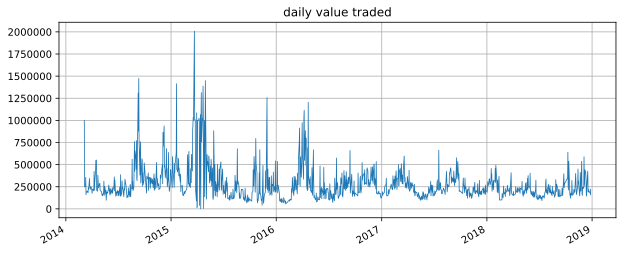

In [23]:
traded_value.plot(    
    figsize=(10,4), 
    linewidth=0.8, 
    title='daily value traded',
    grid=True
)

In [24]:
print('日均换手率：', '%.2f%%' % (traded_value.mean()/10**6*100))

日均换手率： 28.27%


# 收益对比

In [25]:
# 与基准收益（hs300）对比

hs300_price = pro.index_daily(ts_code='399300.SZ', start_date='20140305', end_date='20190101')
hs300_price.index = pd.to_datetime(hs300_price['trade_date'])
hs300_price.sort_index(inplace=True)
hs300_price

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2014-03-05,399300.SZ,20140305,2163.9760,2187.3520,2189.0930,2159.5950,2184.2730,-20.2970,-0.9292,61332015.0,5.566968e+07
2014-03-06,399300.SZ,20140306,2173.6340,2159.3970,2181.4270,2136.4540,2163.9760,9.6580,0.4463,69093767.0,6.149502e+07
2014-03-07,399300.SZ,20140307,2168.3580,2170.0430,2189.3900,2161.4360,2173.6340,-5.2760,-0.2427,64265177.0,5.869318e+07
2014-03-10,399300.SZ,20140310,2097.7870,2149.6760,2149.6760,2095.0670,2168.3580,-70.5710,-3.2546,71416407.0,6.308641e+07
2014-03-11,399300.SZ,20140311,2108.6610,2092.6080,2118.7900,2088.7290,2097.7870,10.8740,0.5184,57621243.0,5.307578e+07
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,399300.SZ,20181224,3038.1981,3015.4974,3040.3524,3007.3292,3029.3951,8.8030,0.2906,57299615.0,6.388074e+07
2018-12-25,399300.SZ,20181225,3017.2815,3006.8787,3030.1418,2964.8750,3038.1981,-20.9166,-0.6885,78689425.0,8.041357e+07
2018-12-26,399300.SZ,20181226,3002.0327,3012.8690,3029.0608,2996.4829,3017.2815,-15.2488,-0.5054,55647032.0,5.857497e+07


In [26]:
base_return = hs300_price['open'].diff()/hs300_price['open'].shift(1)

In [27]:
returns = pd.concat([factor_return, base_return.to_frame()], axis=1)
returns.columns = ['factor_return', 'hs300_return']
returns = returns.iloc[:-1,].fillna(0)
returns

,factor_return,hs300_return
2014-03-05,0.000000,0.000000
2014-03-06,0.001564,-0.012780
2014-03-07,-0.005659,0.004930
2014-03-10,-0.029211,-0.009386
2014-03-11,0.007145,-0.026547
...,...,...
2018-12-21,-0.009232,-0.009151
2018-12-24,-0.000943,-0.013036
2018-12-25,-0.003995,-0.002858
2018-12-26,0.012298,0.001992


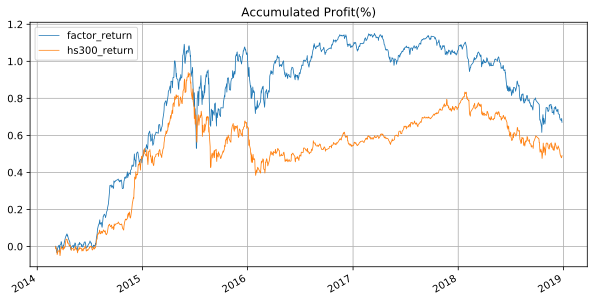

In [28]:
returns.cumsum().plot(
    figsize=(10,5), 
    linewidth=0.8, 
    legend=True, 
    title='Accumulated Profit(%)', 
    grid=True
)

In [29]:
stat = returns.dropna().describe().T
stat['Sharpe'] = stat['mean']*(250)**0.5/stat['std']
stat

,count,mean,std,min,25%,50%,75%,max,Sharpe
factor_return,1180.0,0.000568,0.020801,-0.127913,-0.007238,0.001133,0.008828,0.159462,0.431727
hs300_return,1180.0,0.000416,0.016425,-0.111327,-0.006046,0.000661,0.007902,0.081341,0.400465


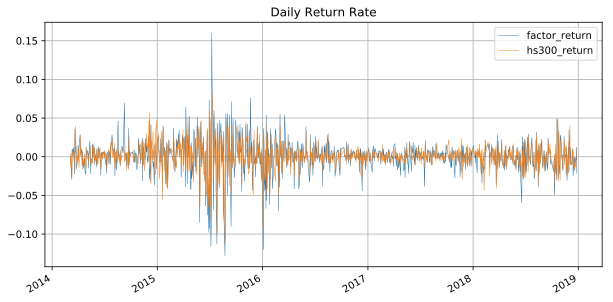

In [30]:
returns.plot(
    figsize=(10,5),
    linewidth=0.5,
    title='Daily Return Rate',
    grid=True
)

# Summary

In [31]:
summary = factor_return*100
summary = summary.rename(columns={'1D':'daily profit(%)'})
summary['daily profit(rmb)'] =  summary['daily profit(%)']*10**4
summary['accumulated profit(rmb)'] =  summary['daily profit(rmb)'].cumsum()

summary['instrument holdings count'] = factor_data.groupby(level=0)['factor'].count()

# 没有设置股票的最大头寸限制，所以只要instrument holdings count不为0，则stock holding value=1000000
summary['stock holding value'] = np.where(summary['instrument holdings count']>0, 10**6, 0)
summary['cash value'] = 10**6-summary['stock holding value']

summary['daily value traded'] = traded_value

summary
# summary.to_csv('summary.csv')

,daily profit(%),daily profit(rmb),accumulated profit(rmb),instrument holdings count,stock holding value,cash value,daily value traded
date,,,,,,,
2014-03-06,0.156384,1563.839847,1563.839847,201,1000000,0,1000000.000000
2014-03-07,-0.565850,-5658.504272,-4094.664425,198,1000000,0,247269.236042
2014-03-10,-2.921144,-29211.436154,-33306.100580,213,1000000,0,257407.285843
2014-03-11,0.714468,7144.681252,-26161.419327,251,1000000,0,356197.581193
2014-03-12,0.980172,9801.716540,-16359.702787,244,1000000,0,159795.469514
...,...,...,...,...,...,...,...
2018-12-21,-0.923194,-9231.940713,683964.917490,225,1000000,0,187366.768631
2018-12-24,-0.094298,-942.982183,683021.935307,239,1000000,0,193982.998154
2018-12-25,-0.399475,-3994.750558,679027.184750,230,1000000,0,176316.577722


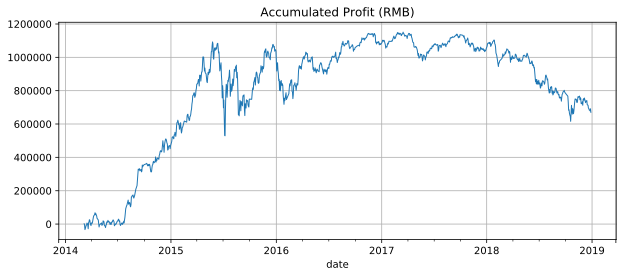

In [32]:
summary['accumulated profit(rmb)'].plot(
    figsize=(10,4), 
    linewidth=1, 
    title='Accumulated Profit (RMB)',
    grid=True
)